In [1]:
import glob
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
if not os.path.isdir('data'):
    pass

# Download data from kaggle


In [3]:
if not os.path.isfile('data/train_folds.csv'):
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    df = pd.read_csv('data/train.csv')
    print(df.head())
    df.loc[:, 'kfold'] = -1

    df = df.sample(frac=1).reset_index(drop=True)

    X = df.image_id.values
    y = df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values

    mskf = MultilabelStratifiedKFold(n_splits=5)

    for fold, (_trn, _val) in enumerate(mskf.split(X, y)):
        print('Train: ', _trn, 'VAL: ', _val)
        df.loc[_val, 'kfold'] = fold

    print('folds: ', df.kfold.value_counts())
    df.to_csv('data/train_folds.csv')


In [4]:
if not os.path.isdir('data/train_images'):
    files = glob.glob('data/train_image_data_*.parquet')

    for f in files:
        df = pd.read_parquet(f)
        image_ids = df.image_id.values
        df = df.drop('image_id', axis=1)
        images = df.values.reshape(-1, 137, 236)

        for j, img_id in tqdm(enumerate(image_ids), total=len(image_ids)):
            img = Image.fromarray(images[j])
            img.save(f'data/train_images/{img_id}.png')


In [5]:
class BengaliDatasetTrain(Dataset):
    def __init__(self,
                 folds,
                 transform=None,
                 preload=False,
                 n_images=None):
        """ Intialize the BengaliDatasetTrain dataset

        Args:
            - folds: number of folds to use
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
            - n_images: load specific number of items can be used for debugging purposes
        """
        self.images = None
        self.transform = transform

        df = pd.read_csv('data/train_folds.csv')
        df = df[df.kfold.isin(folds)].reset_index(drop=True)

        df = df[['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'kfold']].reset_index(drop=True)

        if n_images:
            df = df[:n_images]

        self.image_id = df.image_id.values
        self.grapheme_root = df.grapheme_root.values
        self.vowel_diacritic = df.vowel_diacritic.values
        self.consonant_diacritic = df.consonant_diacritic.values

        # if preload dataset into memory
        if preload:
            self._preload()

    def _preload(self):
        """
        Preload images to memory
        """
        self.images = []

        print('Preloading data...')
        for image_fn in tqdm(self.image_id, total=len(self.image_id)):
            # load images
            image = Image.open(f'data/train_images/{image_fn}.png')
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
        else:
            # If on-demand data loading
            image = Image.open(f'data/train_images/{self.image_id[index]}.png')

        image = image.convert('RGB')
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)

        return {
            'image': image,
            'grapheme_root': torch.tensor(self.grapheme_root[index], dtype=torch.long),
            'vowel_diacritic': torch.tensor(self.vowel_diacritic[index], dtype=torch.long),
            'consonant_diacritic': torch.tensor(self.consonant_diacritic[index], dtype=torch.long)
        }

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return len(self.image_id)


In [6]:
def show_imgs(dataset, nrow=5, ncol=5, figsize=(20, 8)):
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        image = np.array(dataset[i]['image']).astype(np.uint8)
        ax.imshow(image, cmap='Greys')
    plt.tight_layout()
    plt.show()

In [7]:
dataset = BengaliDatasetTrain([1, 2])

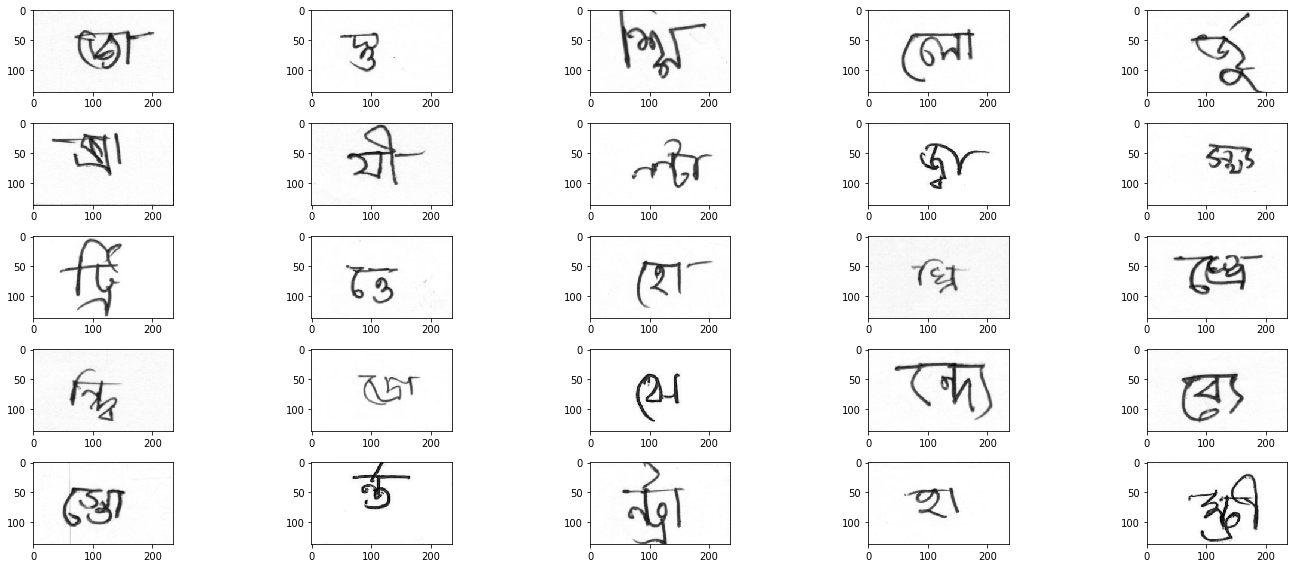

In [8]:
show_imgs(dataset)

In [9]:
import pretrainedmodels

class ResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18, self).__init__()

        if pretrained:
            self.model = pretrainedmodels.models.resnet18(pretrained='imagenet')
        else:
            self.model = pretrainedmodels.models.resnet18(pretrained=False)

        self.l0 = nn.Linear(512, 168)
        self.l1 = nn.Linear(512, 11)
        self.l2 = nn.Linear(512, 7)

    def forward(self, x):
        N = x.shape[0]

        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(N, -1)
        s0 = self.l0(x)
        s1 = self.l1(x)
        s2 = self.l2(x)
        return s0, s1, s2


In [10]:
MODEL_DISPATCHER = {
    'resnet18': ResNet18
}


In [11]:
from sklearn.metrics import recall_score

def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()

    recall_grapheme = recall_score(pred_labels[0], y[:, 0], average='macro', )
    recall_vowel = recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = recall_score(pred_labels[2], y[:, 2], average='macro')
    final_score = np.average([recall_grapheme, recall_vowel, recall_consonant], weights=[2, 1, 1])

    print(f'recall:grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}')
    return final_score

In [12]:
import copy

def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_macro_recall = 0.0

    history = {
        'train_recall': [],
        'train_loss': [],
        'val_recall': [],
        'val_loss': [],
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            final_outputs = []
            final_targets = []

            # Iterate over data.
            for i, d in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase])):
                image = d['image'].to(DEVICE)
                grapheme_root = d['grapheme_root'].to(DEVICE)
                vowel_diacritic = d['vowel_diacritic'].to(DEVICE)
                consonant_diacritic = d['consonant_diacritic'].to(DEVICE)

                targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(image)
                    loss = criterion(outputs, targets)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                final_outputs.append(torch.cat(outputs, dim=1))
                final_targets.append(torch.stack(targets, dim=1))

            final_outputs = torch.cat(final_outputs)
            final_targets = torch.cat(final_targets)
            macro_recall_score = macro_recall(final_outputs, final_targets)
            epoch_loss = running_loss / len(dataloaders[phase])

            # Reduce learning rate when a validation loss has stopped improving.
            if phase == 'val':
                scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Macro recall: {macro_recall_score:.4f}')

            history[f'{phase}_recall'].append(macro_recall_score)
            history[f'{phase}_loss'].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and macro_recall_score > best_macro_recall:
                best_macro_recall = macro_recall_score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Macro recall: {best_macro_recall:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [15]:
def plot_graph(history, epoch):
    val_loss, val_recall = history['val_loss'], history['val_recall']
    train_loss, train_recall = history['train_loss'], history['train_recall']
    epochsx = np.arange(epoch)

    plt.subplot(3, 1, 1)
    plt.title('Loss on train and validation sets')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochsx, val_loss, '-^', label='val loss')
    plt.plot(epochsx, train_loss, '-o', label='train loss')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title('Accuracy on train and validation sets')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epochsx, val_recall, '-^', label='val recall')
    plt.plot(epochsx, train_recall, '-o', label='train recall')
    plt.legend()

In [13]:
def loss_fn(outputs, targets):
    o1, o2, o3 = outputs
    t1, t2, t3 = targets
    l1 = F.cross_entropy(o1, t1)
    l2 = F.cross_entropy(o2, t2)
    l3 = F.cross_entropy(o3, t3)
    return (l1 + l2 + l3) / 3

In [14]:
import ast
from torchvision import transforms as T

DEVICE = os.environ.get('DEVICE', 'cuda')
IMG_HEIGHT = int(os.environ.get('IMG_HEIGHT', 137))
IMG_WEIGHT = int(os.environ.get('IMG_WEIGHT', 236))
EPOCH = int(os.environ.get('EPOCH', 25))

TRAIN_BATCH_SIZE = int(os.environ.get('TRAIN_BATCH_SIZE', 16))
TEST_BATCH_SIZE = int(os.environ.get('TEST_BATCH_SIZE', 8))
PRELOAD_DATASET = os.environ.get('PRELOAD_DATASET', '1') == '1'

BASE_MODEL = os.environ.get('BASE_MODEL', 'resnet18')

# DEBUG = os.environ.get('DEBUG', '0') == '1'
DEBUG = True

if DEBUG:
    n_images = 1000
    TRAIN_FOLDS = (0, 1, 2, 3)
    VAL_FOLDS = (4,)
else:
    TRAIN_FOLDS = ast.literal_eval(os.environ.get('TRAIN_FOLDS'))
    VAL_FOLDS = ast.literal_eval(os.environ.get('TEST_FOLDS'))

model = MODEL_DISPATCHER[BASE_MODEL](pretrained=True)
model.to(DEVICE)


train_dataset = BengaliDatasetTrain(
    folds=TRAIN_FOLDS,
    transform=T.Compose([
        T.RandomResizedCrop((IMG_HEIGHT, IMG_WEIGHT)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    preload=PRELOAD_DATASET,
    n_images=n_images
)

val_dataset = BengaliDatasetTrain(
    folds=VAL_FOLDS,
    transform=T.Compose([
        T.Resize((IMG_HEIGHT, IMG_WEIGHT)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    preload=PRELOAD_DATASET,
    n_images=n_images
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False
)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 patience=5,
                                                 factor=0.3, verbose=True)

 25%|██▍       | 247/1000 [00:00<00:00, 2462.97it/s]

Preloading data...


 25%|██▌       | 250/1000 [00:00<00:00, 2493.45it/s]

Preloading data...


100%|██████████| 1000/1000 [00:00<00:00, 2447.51it/s]


  2%|▏         | 1/63 [00:00<00:10,  5.93it/s]

Epoch 0/4
----------


100%|██████████| 63/63 [00:10<00:00,  6.23it/s]
/home/vova/anaconda3/envs/cs231n/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▍         | 3/63 [00:00<00:02, 21.16it/s]

recall:grapheme 0.0025456988162823177, vowel 0.2051093564725304, consonant 0.11622253636495751
train Loss: 2.6674 Macro recall: 0.0816


  0%|          | 0/63 [00:00<?, ?it/s]

recall:grapheme 0.0004892325460204786, vowel 0.40713110793242585, consonant 0.3477601050634758
val Loss: 2.5683 Macro recall: 0.1890

Epoch 1/4
----------


  5%|▍         | 3/63 [00:00<00:02, 21.39it/s]

recall:grapheme 0.004257832935877092, vowel 0.23576866561659512, consonant 0.258159443552702
train Loss: 2.5891 Macro recall: 0.1256


  0%|          | 0/63 [00:00<?, ?it/s]

recall:grapheme 0.0020302836657976847, vowel 0.41425790004140556, consonant 0.23232178643000287
val Loss: 2.4672 Macro recall: 0.1627

Epoch 2/4
----------


  5%|▍         | 3/63 [00:00<00:02, 21.69it/s]

recall:grapheme 0.002215881846958184, vowel 0.29963185301204004, consonant 0.21192699192699194
train Loss: 2.4823 Macro recall: 0.1290


  2%|▏         | 1/63 [00:00<00:10,  6.15it/s]

recall:grapheme 0.0031481047601867916, vowel 0.4073649992923784, consonant 0.3434646773230404
val Loss: 2.4912 Macro recall: 0.1893

Epoch 3/4
----------


  3%|▎         | 2/63 [00:00<00:03, 17.32it/s]

recall:grapheme 0.0029324223857422364, vowel 0.27614795058218156, consonant 0.2656998385475206
train Loss: 2.4554 Macro recall: 0.1369


  2%|▏         | 1/63 [00:00<00:10,  6.19it/s]

recall:grapheme 0.0019903237725875525, vowel 0.4203416186812598, consonant 0.4442074911499372
val Loss: 2.3509 Macro recall: 0.2171

Epoch 4/4
----------


  5%|▍         | 3/63 [00:00<00:02, 21.74it/s]

recall:grapheme 0.00564534439410154, vowel 0.30096461494637966, consonant 0.47400558880411775
train Loss: 2.3937 Macro recall: 0.1966


100%|██████████| 63/63 [00:02<00:00, 21.73it/s]


recall:grapheme 0.003815523863947448, vowel 0.4561544794454273, consonant 0.45869553819820325
val Loss: 2.2597 Macro recall: 0.2306

Best val Macro recall: 0.230620


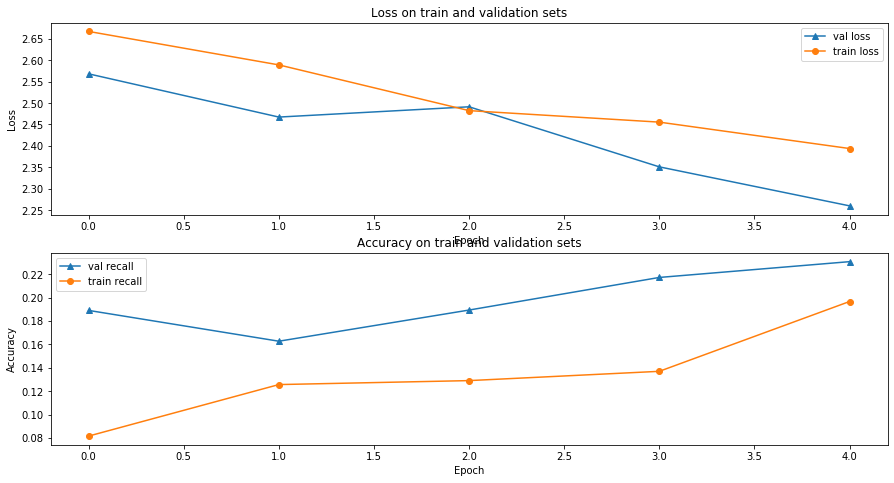

In [17]:
EPOCH = 5
model, history = train_model(dataloaders, model, loss_fn, optimizer, scheduler, EPOCH)
plot_graph(history, EPOCH)
